In [1]:
import numpy as np
import pandas as pd
import os.path as path
import random

data_path = "../data/"
results_path = "../results/archive/"
kernels = pd.read_csv(data_path+'kernel_list.csv')
runtimes_path = results_path+"T4_18-6-3_sm52.csv"
run_times = pd.read_csv(runtimes_path,low_memory=False)
# Pathnames cleanup
run_times['path'] = run_times['path'].apply(lambda x: x.replace('step2/', data_path+'kernels/').replace('/main.cu', ''))

Add the file path to the dataframe

In [2]:
kernels['kernel_path'] = [data_path+"kernels/"+str(r["Repo"])+"/"+str(r["underdirectory"]) 
                        for _, r in kernels.iterrows()]

Explore the dataset

In [3]:
kernels.head()

Repo  underdirectory               function status  \
0     1               0       euclidean_kernel   runs   
1     1               1  euclidean_kernel_same   runs   
2     1               2         maximum_kernel   runs   
3     1               3    maximum_kernel_same   runs   
4     1               4       manhattan_kernel   runs   

                                           variables          kernel_path  
0  [('const float *', 'vg_a'), ('size_t', 'pitch_...  ../data/kernels/1/0  
1  [('const float *', 'vg_a'), ('size_t', 'pitch_...  ../data/kernels/1/1  
2  [('const float *', 'vg_a'), ('size_t', 'pitch_...  ../data/kernels/1/2  
3  [('const float *', 'vg_a'), ('size_t', 'pitch_...  ../data/kernels/1/3  
4  [('const float *', 'vg_a'), ('size_t', 'pitch_...  ../data/kernels/1/4

In [4]:
print(len(kernels))

20258


In [5]:
run_times.head()

path          function     blocks        matrix         time
0  ../data/kernels/1/0  euclidean_kernel  (1, 1024)  (1016, 1016)  2970.211154
1  ../data/kernels/1/0  euclidean_kernel  (1, 1024)  (1232, 1232)  2786.452857
2  ../data/kernels/1/0  euclidean_kernel  (1, 1024)      (16, 16)  3124.981053
3  ../data/kernels/1/0  euclidean_kernel  (1, 1024)  (1680, 1680)  2591.644286
4  ../data/kernels/1/0  euclidean_kernel  (1, 1024)  (2024, 2024)  2476.894286

Try to create a ProGraML graph from LLVM IR compiled kernels

In [6]:
CREATE_GRAPHS = False

In [7]:
import glob
import os
from tqdm import tqdm

In [8]:
files = glob.glob(os.path.join(data_path, 'kernels', '*', '*', '*.ll'), recursive=True)
if CREATE_GRAPHS:
    num_created_graphs = 0
    print(f"Found {len(files)} LLVM-IR files to convert")
    for i in tqdm(range(len(files))):
        llvm_filename = files[i]
        function_name = llvm_filename.split('/')[-1].split('.')[0]
        kernel_path = os.path.dirname(llvm_filename)
        graph_filename = os.path.join(kernel_path, f'{function_name}.graph')
        if not os.path.exists(graph_filename):
            # Open the LLVM-IR file
            with open(files[i], 'r') as f:
                llvm_program = f.read()
            # Create the ProgramGraph object from the LLVM-IR. 
            # Use a timeout of 5 seconds to filter out large programs
            # and avoid locks.
            try:
                graph = programl.from_llvm_ir(llvm_program, timeout=5)
            # Write a representation of the graphs to a file
            except TimeoutError:
                print(f'Timeout while processing graph for {files[i]}')
                continue
            except programl.GraphCreationError as e:
                print(f'Error while processing graph for {files[i]}: {e}')
                continue
            # Filter out graphs with only 1 node
            if len(graph.node) > 1:
                # If no error occured, write graph to file
                programl.save_graphs(graph_filename, [graph])
                # The graph was created successfully
                num_created_graphs += 1
else:
    graph_files = glob.glob(os.path.join(data_path, 'kernels', '*', '*', '*.graph'), recursive=True)
    print(f"Found {len(files)} LLVM-IR files")
    print(f"Found {len(graph_files)} graph files")

Found 20044 LLVM-IR files
Found 20043 graph files


Create full list and small list of valid indexes to use in the kernels dataset and for each create their training and testval sets

In [9]:
full_idxs = [   
    i
    for i, gpath in enumerate(
    (kernels['kernel_path'] + os.sep + kernels['function'] + '.graph').unique())
    if os.path.exists(gpath)
]

full_train = random.sample(full_idxs, int(len(full_idxs)*0.8))
sfullt = set(full_train)
full_test = [i for i in full_idxs if i not in sfullt]

len(full_idxs), len(full_train), len(full_test)

(20043, 16034, 4009)

In [10]:
small_idxs = random.sample(full_idxs, 1000)

small_train = random.sample(small_idxs, int(len(small_idxs)*0.8))
ssmallt = set(small_train)
small_test = [i for i in small_idxs if i not in ssmallt]

len(small_idxs), len(small_train), len(small_test)

(1000, 800, 200)

In [11]:
import pickle
import json

with open('../data/full_idx_list.pickle', 'wb') as f:
    pickle.dump(full_idxs, f)
with open('../data/lscat_idxs.json', 'w') as f:
    json.dump({'train': full_train, 'testval': full_test}, f)

with open('../data/small_idx_list.pickle', 'wb') as f:
    pickle.dump(small_idxs, f)
with open('../data/small_lscat_idxs.json', 'w') as f:
    json.dump({'train': small_train, 'testval': small_test}, f)

In [12]:
kernels = kernels.iloc[full_idxs]

The matrix sizes and block sizes that are reported are:

In [13]:
allowed_blocks=['(8, 8)','(16, 16)'  ,'(24, 24)','(32, 32)','(1, 64)','(1, 128)',
                '(1, 192)','(1, 256)','(1, 320)','(1, 384)','(1, 448)','(1, 512)',
                '(1, 576)','(1, 640)','(1, 704)','(1, 768)','(1, 832)','(1, 896)',
                '(1, 960)','(1, 1024)']
allowed_matrix=['(240, 240)','(496, 496)','(784, 784)','(1016, 1016)',
                '(1232, 1232)','(1680, 1680)','(2024, 2024)']

In [14]:
ok_matrix = run_times[run_times['matrix'].isin(allowed_matrix)].index
ok_block  = run_times[run_times['blocks'].isin(allowed_blocks)].index
ok_index  = ok_matrix.intersection(ok_block)
proc_run_times = run_times.iloc[ok_index]

In [15]:
print(f'Removed {len(run_times) - len(proc_run_times)} unrelated rows. Left {len(proc_run_times)} rows')

Removed 402141 unrelated rows. Left 2531763 rows


In [16]:
prior_len = len(proc_run_times)
proc_run_times = proc_run_times.loc[np.logical_and(proc_run_times['path'].isin(kernels['kernel_path']),
                                    proc_run_times['function'].isin(kernels['function']))]
print(f'Removed {prior_len - len(proc_run_times)} unrelated rows. Left {len(proc_run_times)} rows')

Removed 27605 unrelated rows. Left 2504158 rows


In [17]:
df = proc_run_times.set_index(['path', 'function', 'matrix', 'blocks']).unstack('blocks')
df = df.reindex(columns=sorted(df.columns, key=lambda x: x[::-1]))
df.columns = ['block_{}'.format(t) for _, t in df.columns]
df.fillna(np.inf, inplace=True)

In [36]:
def get_labels(idx: int, const: float) -> np.ndarray:
    row = proc_run_times.iloc[idx]
    times = df.loc[row['path'], row['function'], row['matrix']]
    # Transf. #1
    s = times.min() / times
    # Transf. #2
    l = np.exp(s * const)
    l /= np.sum(l)
    l /= l.max()
    return pd.DataFrame(data=[l, s, times], index=['labels', 'performance', 'times'])

get_labels(random.randint(0, len(proc_run_times)), 12)

block_(1, 1024)  block_(1, 128)  block_(1, 192)  block_(1, 256)  \
labels              0.768494        0.188587        0.175910        0.186863   
performance         0.978056        0.860984        0.855185        0.860218   
times            2688.106667     3053.623333     3074.330000     3056.340000   

             block_(1, 320)  block_(1, 384)  block_(1, 448)  block_(1, 512)  \
labels             0.186372        0.282978        0.230612        0.280039   
performance        0.859999        0.894801        0.877748        0.893931   
times           3057.120000     2938.216667     2995.300000     2941.076667   

             block_(1, 576)  block_(1, 64)  block_(1, 640)  block_(1, 704)  \
labels             0.209583       0.176585        0.241173        0.864806   
performance        0.869780       0.855504        0.881480        0.987896   
times           3022.740000    3073.183333     2982.620000     2661.333333   

             block_(1, 768)  block_(1, 832)  block_(1, 896)  block_(1, 960)  \
labels             0.935202            1.00        0.778706        0.961151   
performance        0.994417            1.00        0.979156        0.996698   
times           2643.880000         2629.12     2685.086667     2637.830000   

             block_(16, 16)  block_(24, 24)  block_(32, 32)  block_(8, 8)  
labels             0.235814        0.203412        0.209634      0.241353  
performance        0.879607        0.867290        0.869801      0.881542  
times           2988.970000     3031.420000     3022.670000   2982.410000

In [38]:
if not os.path.exists('../data/T4_perf.pickle'):

    cols = [get_labels(i, 12).loc['performance'].to_numpy() 
            for i in range(len(proc_run_times))]

    with open('../data/T4_perf.pickle', 'wb') as f:
        pickle.dump(cols, f)

In [39]:
if not os.path.exists('../data/T4_times.pickle'):
    
    ts = [get_labels(i).loc['times'].to_numpy() 
          for i in tqdm(range(len(proc_run_times)))]

    with open('../data/T4_times.pickle', 'wb') as f:
        pickle.dump(ts, f)

In [40]:
with open('../data/T4_perf.pickle', 'rb') as f:
    cols = pickle.load(f)
with open('../data/T4_times.pickle', 'rb') as f:
    times = pickle.load(f)

In [41]:
cols = np.stack(cols)
times = np.stack(times)

Random choice

In [42]:
# Check random score
random_scores = []
for _ in tqdm(range(100)):
    idxs = np.random.rand(*cols.shape).argsort(1)[:,:1]
    sel_ = np.take_along_axis(cols, idxs, axis=1)
    random_scores.append(np.mean(sel_))        

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


In [43]:
np.mean(random_scores), np.std(random_scores)

(0.9234612481492526, 5.36325688433613e-05)

(1D-1024) choice

In [44]:
np.mean(cols[:, 0]), np.std(cols[:, 0])  

(0.9326978546139842, 0.1140381396386585)

Improvements (absolute). Note: times are in MICROSECONDS.

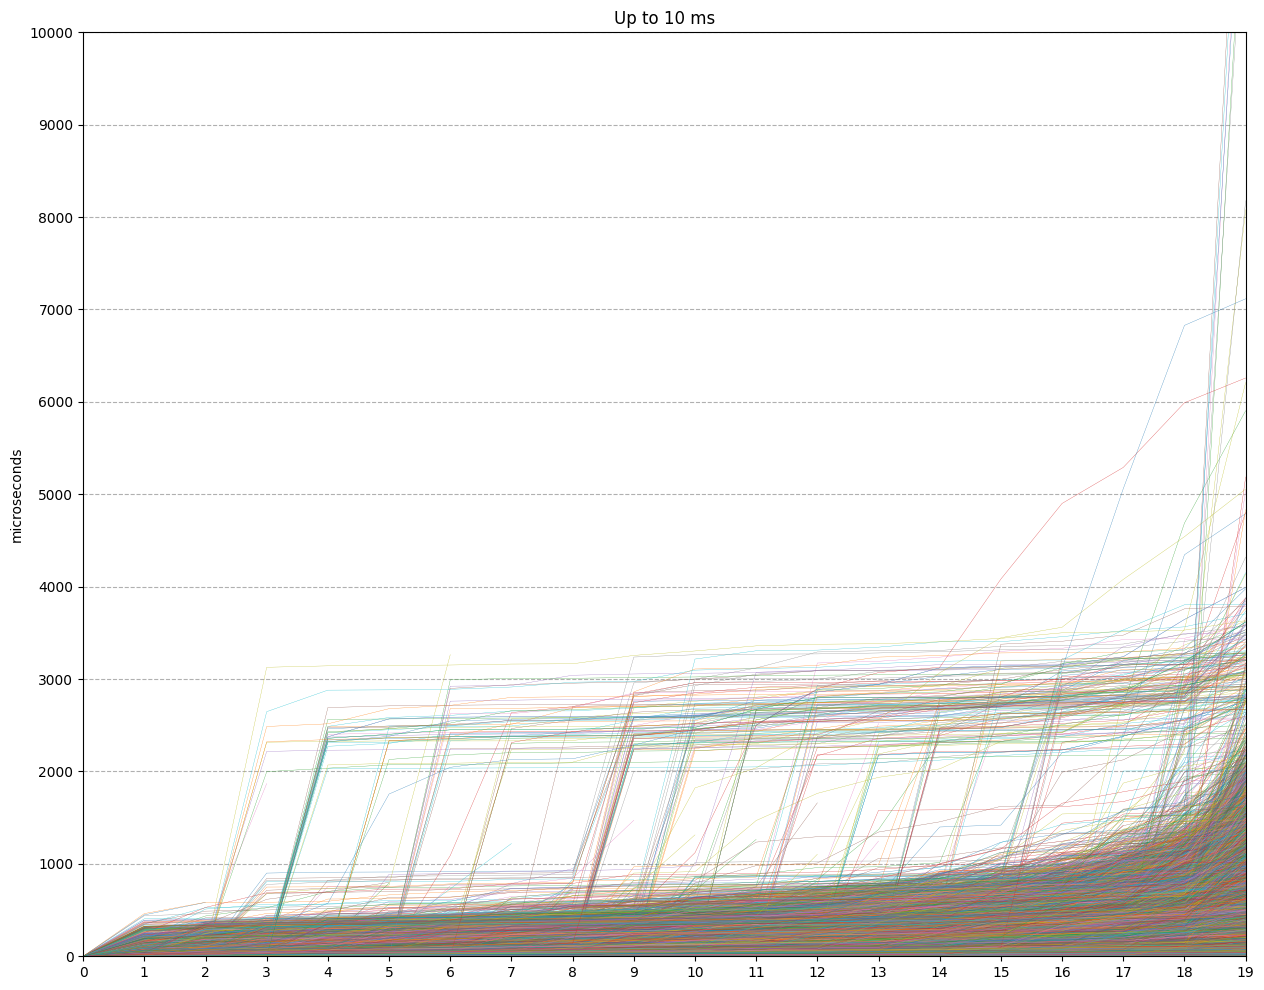

In [45]:
import matplotlib.pyplot as plt

def add_to_graph(idx, ax):
    t = sorted(times[idx])
    t = t - t[0]
    ax.plot(t, linewidth=0.2)

fig, ax = plt.subplots(1, 1, figsize=(15,12))

for i in random.sample(range(len(times)), 10_000):
    add_to_graph(i, ax)

ax.set_title('Up to 10 ms')
ax.set_ylim(0, 10_000);
ax.set_xlim(0, 19);
ax.set_yticks(range(0, 11_000, 1_000))    # Visible up to 10 ms
ax.set_ylabel('microseconds')
ax.set_xticks(range(0, 20, 1));
ax.grid(visible=True, which='major', axis='y', linestyle='--')

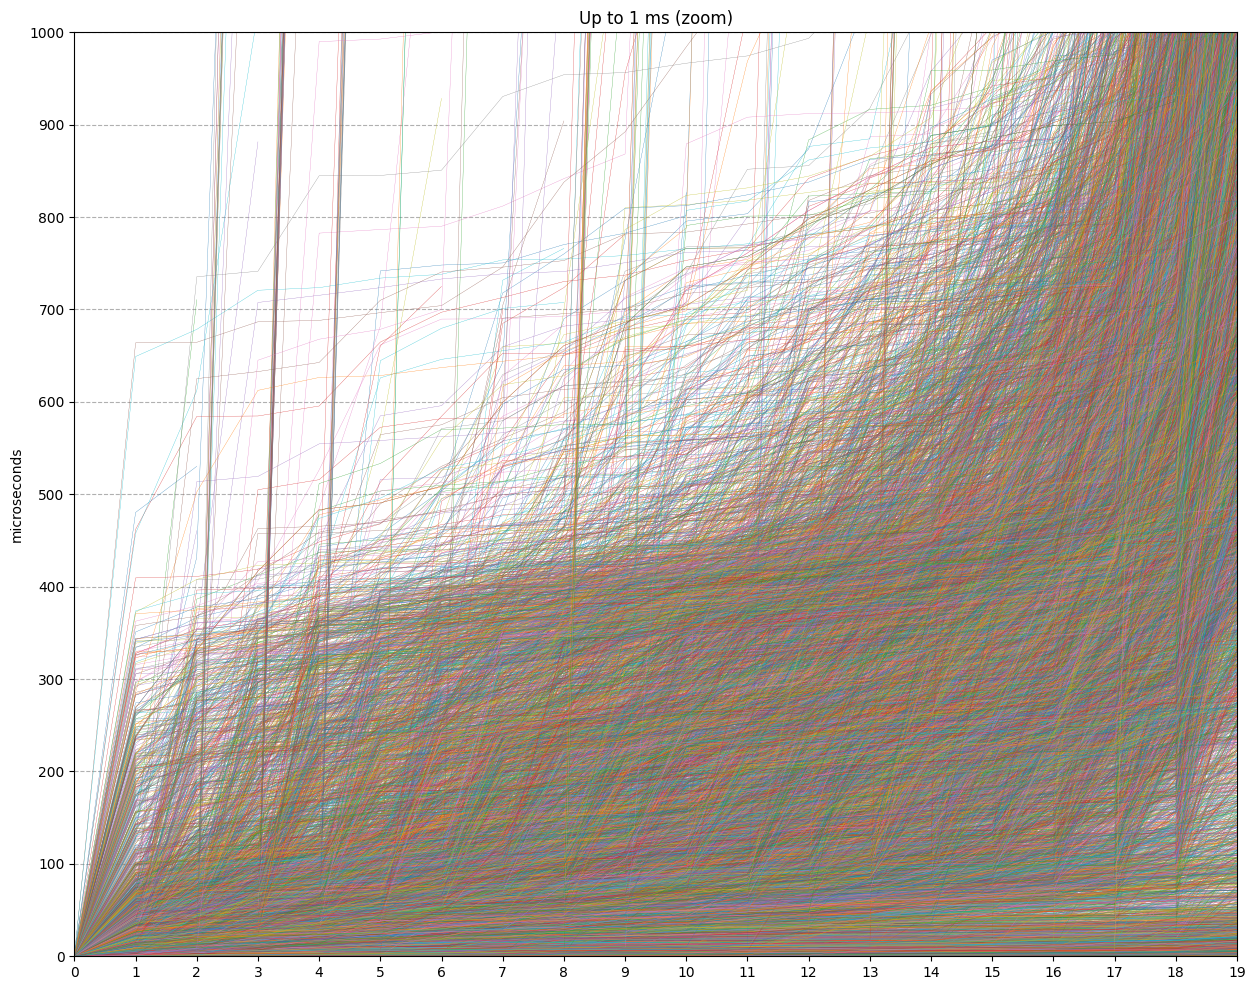

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(15,12))

for i in random.sample(range(len(times)), 10_000):
    add_to_graph(i, ax)

ax.set_title('Up to 1 ms (zoom)')
ax.set_ylim(0, 1000);
ax.set_xlim(0, 19);
ax.set_yticks(range(0, 1100, 100))    # Visible up to 10 ms
ax.set_ylabel('microseconds')
ax.set_xticks(range(0, 20, 1));
ax.grid(visible=True, which='major', axis='y', linestyle='--')

Relative

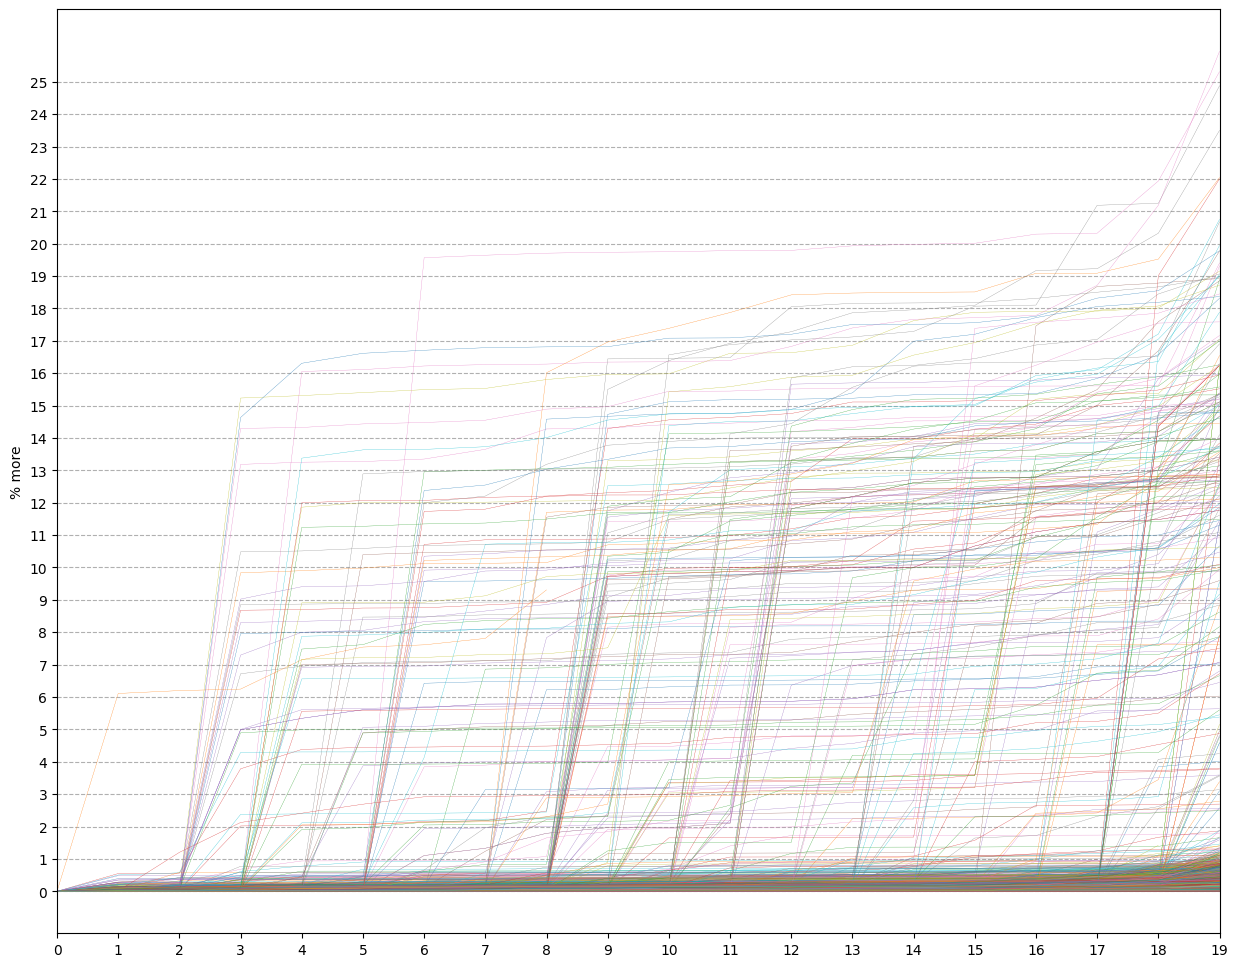

In [47]:
import matplotlib.pyplot as plt

def add_to_graph_rel(idx, ax):
    t = sorted(times[idx])
    t = (t / t[0]) - 1.
    ax.plot(t, linewidth=0.2)

fig, ax = plt.subplots(1, 1, figsize=(15,12))

for i in random.sample(range(len(times)), 10_000):
    add_to_graph_rel(i, ax)

ax.set_ylabel('% more')
ax.set_xlim(0, 19);
ax.set_xticks(range(0, 20, 1));
ax.set_yticks(range(0, 26, 1));
ax.grid(visible=True, which='major', axis='y', linestyle='--')